In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
import numpy as np
import time
import matplotlib.pyplot as plt

#VG-Cos Method
$$C = e^{-rt}\sum_{k=0}^{N-1} \operatorname{Re} \left\{ e^{iu\mu t}\cdot \left(1- iu\theta\nu + \frac{\sigma^2\nu u^2}{2}\right)^{\frac{-t}{\nu}} \cdot e^{iux} \cdot e^{-iua} \right\} \cdot \left(  \frac{2}{b-a} K\left[\chi_{k}(0, b)-\varphi_{k}(0, b)\right] \right)$$

\begin{align}
u &= \frac{k\pi}{b-a}\\
\mu &= r-q+\frac{1}{\nu}ln\left( 1-\theta\nu-\frac{\sigma^2\nu}{2} \right)\\
x &= log\left( \frac{S_0}{K}\right)
\end{align}


\begin{align}
 \psi_{k}(c, d) =  \begin{cases}{\left[\sin \left(k \pi \frac{d-a}{b-a}\right)-\sin \left(k \pi \frac{c-a}{b-a}\right)\right] \frac{b-a}{k \pi}} & k \neq 0 \\ (d-c) & k=0 .\end{cases}
 \end{align}

\begin{align}
\chi_{k}(c, d) = \frac{1}{1+\left(\frac{k \pi}{b-a}\right)^{2}}\left[\cos \left(k \pi \frac{d-a}{b-a}\right) e^{d}-\cos \left(k \pi \frac{c-a}{b-a}\right) e^{c}\right. \left.+\frac{k \pi}{b-a} \sin \left(k \pi \frac{d-a}{b-a}\right) e^{d}-\frac{k \pi}{b-a} \sin \left(k \pi \frac{c-a}{b-a}\right) e^{c}\right]
\end{align}

In [2]:
def CHI(a,b,c,d,k):
    A = (k*np.pi)/(b-a)
    val = (1/(1+A**2))*( np.cos(A*(d-a))*np.exp(d)- np.cos(A*(c-a))*np.exp(c) + A*np.sin(A*(d-a))*np.exp(d) - A*np.sin(A*(c-a))*np.exp(c)  )
    return val

def PSI(a,b,c,d,k):
    A = (k*np.pi)/(b-a)
    if k == 0:
        val = d-c 
    else:
        val = A**(-1)*( np.sin(A*(d-a)) - np.sin(A*(c-a)) )
    return val

def V_call(K,a,b,k):
    val = (2/(b-a))*K*(CHI(a,b,0,b,k)-PSI(a,b,0,b,k))
    return val

def VG_CHARAC(S0,K,T,r,a,b,sig,theta,nu,k):
    i = complex(0,1)
    x = np.log(S0/K)
    u = (k*np.pi)/(b-a)
    mu = r + ( 1/nu*(np.log(1-theta*nu-0.5*sig**2*nu)) )
    val = np.exp(i*u*x) * np.exp(i*u*mu*T) * (1-i*u*theta*nu+0.5*sig**2*nu*u**2)**(-T/nu) #VG characteristic function
    return val

def VG_EuroCall(S0,K,T,r,sig,theta,nu,N): #pricing formula
    i = complex(0,1)
    L = 10
    c1 = (r+theta)*T
    c2 = (sig**2 + nu*theta**2)*T
    c4 = 3*(sig**4*nu + 2*theta**4*nu**3 + 4*sig**2*theta**2*nu**2)*T
    a = c1 - L*np.sqrt(c2+ np.sqrt(c4)) 
    b = c1 + L*np.sqrt(c2+ np.sqrt(c4)) 
    P = []
    for k in range(N):
        u = (k*np.pi)/(b-a)
        val = (VG_CHARAC(S0,K,T,r,a,b,sig,theta,nu,k) * np.exp(-i*a*u)).real * V_call(K,a,b,k) 
        P.append(val)
    P[0] = 0.5*P[0] #first term is weighted by half
    val = (sum(P))*np.exp(-r*T)
    return val

#Statistic Function

In [8]:
def STAT(L):
    """
    Statistic function
    Inputs: List/array L
    Outputs: max, min, mean
    """
    print("max = "+str(np.max(L)) )
    print("min = "+str(np.min(L)) )
    print("mean = "+str(np.sum(L)/len(L)) )

#Range for strikes and maturity times
The NN is trained on $5$ stikes and $4$ maurities, thus resulting into a vector of $20$ prices

In [3]:
S0=1.
K=np.array([0.8,0.9,1.0,1.1, 1.2], dtype=np.float32)
T=np.array([.5,.75,1.,1.25], dtype=np.float32)

In [ ]:
r,sig,theta,nu = 0.1,0.2,-0.14,0.2
N = 256
for i in range(len(T)):
    print(VG_EuroCall(S0,K,T[i],r,sig,theta,nu,N)) #example

[0.24244133 0.15607768 0.08371659 0.03516488 0.01227804]
[0.2629346  0.18055701 0.1106998  0.05920353 0.02778986]
[0.28267395 0.2034122  0.13530204 0.0823326  0.04587126]
[0.30167663 0.22500885 0.15832527 0.10457461 0.0648732 ]


# Pricing Neural Network

In [ ]:
VG_pricer=Sequential([
    Dense(16, activation ="relu", input_shape=(4,)),
    Dense(64, activation ="relu"),
    Dense(64, activation ="relu"),
    Dense(32, activation ="relu"),
    Dense(len(K)*len(T)) ])

lr=0.0001
loss = "mse"
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
VG_pricer.compile(loss = loss, optimizer = optimizer,metrics = ['accuracy',metrics.mae])
VG_pricer.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 16)                80        
                                                                 
 dense_11 (Dense)            (None, 64)                1088      
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 20)                660       
                                                                 
Total params: 8,068
Trainable params: 8,068
Non-trainable params: 0
_________________________________________________________________


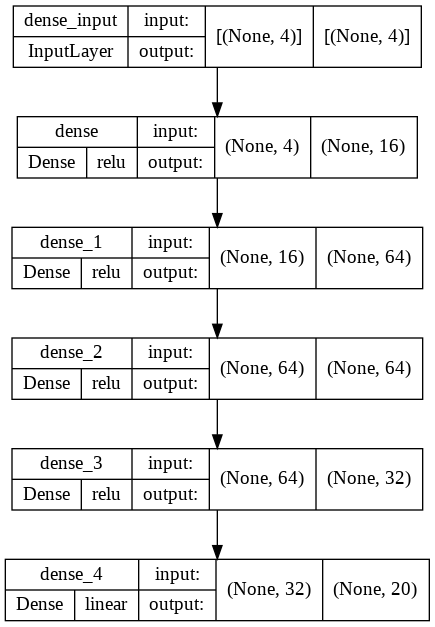

In [ ]:
plot_model(VG_pricer,show_shapes=True,show_layer_activations=True)

#Training
* For each training epoch a new data set is created. This is time cosuming, but it avoids over fitting.
* use random values of $\{r,\sigma,\theta,\nu\}$ for each set, such that;
\begin{align}
r &= [0,0.2]\\
\sigma &= [0.0,0.2]\\
\theta &= [-0.3,0.05]\\
\nu &= [0.0,0.7]\\
\end{align}

* Since the model will be trained with a new data set per epoch, we have to axtract the the loss and accuracy at every epoch

In [ ]:
LOSS = [] #MSE
ACCURACY = []

In [ ]:
num_epochs = 50 #Training epochs
Data_size = 1024 #Training Data Size per epoch

Y_mat = np.zeros((Data_size, len(T),len(K))) 

for n in range(num_epochs):
    r = np.random.uniform(low = 0.0, high = 0.2, size = (Data_size,1) )
    sig = np.random.uniform(low = 0.0, high = 0.2,size = (Data_size,1) )
    theta = np.random.uniform(low = -0.3, high = 0.05,size = (Data_size,1) )
    nu = np.random.uniform(low = 0.0, high = 0.7,size = (Data_size,1) )
    X=np.concatenate([r,sig,theta,nu],axis=1) #Inputs

    for b in range(Data_size):
        for i in range(len(T)):
            Y_mat[b,i,:]= VG_EuroCall(S0,K,T[i],r[b],sig[b],theta[b],nu[b],256)
    Y = Y_mat.reshape((-1,len(K)*len(T))) #Targets, 20 option prices
    
    if n%5==0:
        lr = lr*0.95  #Decreases the learnig rate after every 5 epochs
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
        VG_pricer.compile(loss = loss, optimizer = optimizer,metrics=['accuracy',metrics.mae])

    if n == int(num_epochs/2): #Training marker for half the epochs
         print("half way point")

    history = VG_pricer.fit(X,Y, epochs=1, batch_size = 64) #NN Training
    
    LOSS.append(history.history["loss"][0])
    ACCURACY.append(history.history["accuracy"][0])

16/16 [==============================] - 0s 2ms/step - loss: 3.5997e-04 - accuracy: 0.9844 - mean_absolute_error: 0.0129
half way point
16/16 [==============================] - 0s 2ms/step - loss: 3.4882e-04 - accuracy: 0.9590 - mean_absolute_error: 0.0098


* Training Loss

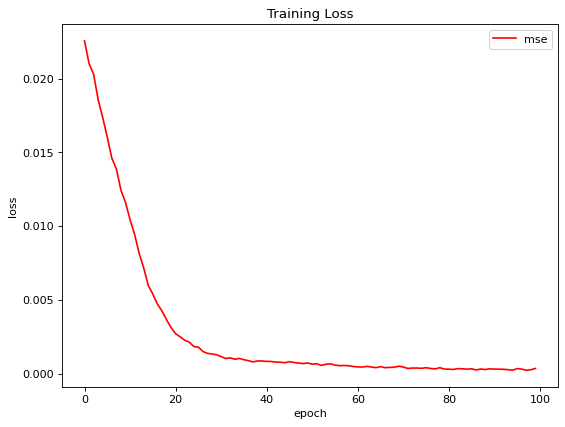

In [ ]:
EPOCH = np.arange(0,len(LOSS))
plt.figure(figsize=(8, 6), dpi=80)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training Loss")
plt.plot(EPOCH,LOSS,color = "r",label ="mse")
plt.legend()
#plt.savefig('training_loss.png')
plt.show()

* Training Accuracy

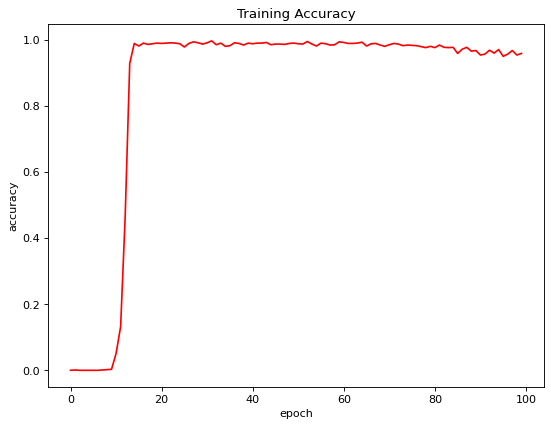

In [ ]:
EPOCH = np.arange(0,len(LOSS))
plt.figure(figsize=(8, 6), dpi=80)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Training Accuracy")
plt.plot(EPOCH,ACCURACY,color = "r")
#plt.savefig('training_accuracy.png')
plt.show()

#Evaluation on unseen data

In [9]:
val_data_size = 1024

r_val = np.random.uniform(low = 0, high = 0.2, size = (val_data_size,1) )
sig_val = np.random.uniform(low = 0.0, high = 0.25,size = (val_data_size,1) )
theta_val = np.random.uniform(low =-0.3, high = 0.06,size = (val_data_size,1) )
nu_val = np.random.uniform(low = 0.0, high = 0.8,size = (val_data_size,1) )

X_val = np.concatenate([r_val,sig_val,theta_val,nu_val],axis=1) #inputs
Y_mat_val = np.zeros((val_data_size, len(T), len(K)))

for b in range(val_data_size):
    for i in range(len(T)):
        Y_mat_val[b,i,:] = VG_EuroCall(S0,K,T[i],r_val[b],sig_val[b],theta_val[b],nu_val[b],256)
        
Y_val = Y_mat_val.reshape((-1,len(K)*len(T))) #Target. 20 0ption prices

VG_pricer.evaluate(X_val, Y_val)

32/32 [==============================] - 0s 2ms/step - loss: 1.0154e-04 - accuracy: 0.9863


[0.0001015408051898703, 0.986328125]

#Comparing predictions against actual prices

In [10]:
r = np.random.uniform(low = 0, high = 0.2)
sig = np.random.uniform(low = 0.0, high = 0.2)
theta = np.random.uniform(low =-0.3, high = 0.05 )
nu = np.random.uniform(low = 0.0, high = 0.7 )

parameters = [r,sig,theta,nu]

y_pred = VG_pricer.predict([parameters]) #Using the pricing NN
y_pred = np.array(tf.reshape(y_pred, (4,5)))

y_act=np.zeros((len(T),len(K)))

for i in range(len(T)):
        y_act[i,:] = VG_EuroCall(S0,K,T[i],r,sig,theta,nu,256)

print(parameters,"parameters","\n"*2)
print(y_pred,"Prediction",2*"\n",y_act,"Actual")

[0.12929426645515016, 0.0948026260011893, 0.01411090288677419, 0.0769972907448297] parameters 


[[0.24148586 0.15303767 0.06844409 0.01301064 0.00655328]
 [0.26490673 0.18432388 0.0971529  0.03256315 0.00944292]
 [0.2946011  0.21365176 0.13068494 0.05397776 0.01642934]
 [0.31712177 0.24166404 0.15474367 0.0841403  0.03797136]] Prediction 

 [[0.25008309 0.1565218  0.06824277 0.01418658 0.00146963]
 [0.27393755 0.18340063 0.0969305  0.03319117 0.006849  ]
 [0.29703328 0.20938599 0.12480928 0.05592175 0.0175102 ]
 [0.31939375 0.23452342 0.15195987 0.08049569 0.03288342]] Actual


#Mean Relative Percentage Error

In [11]:
L = (np.abs(y_pred-y_act)/y_act)*100
print(L,"\n")
L = np.array( tf.reshape(L,(1,20)) )[0]
STAT(L)

[[3.43774743e+00 2.22597106e+00 2.95008761e-01 8.28910289e+00
  3.45914605e+02]
 [3.29667066e+00 5.03404018e-01 2.29434875e-01 1.89210933e+00
  3.78728968e+01]
 [8.18819874e-01 2.03727589e+00 4.70771241e+00 3.47627577e+00
  6.17277253e+00]
 [7.11341414e-01 3.04473714e+00 1.83193444e+00 4.52771524e+00
  1.54726304e+01]] 

max = 345.9146045086213
min = 0.22943487490038272
mean = 22.337908271730594


#Pricing Speed
* pricing the same number of paraeters in each instance to test the speed

In [12]:
for j in range(1000):
    r = np.random.uniform(low = 0, high = 0.2)
    sig = np.random.uniform(low = 0.0, high = 0.2)
    theta = np.random.uniform(low =-0.3, high = 0.05 )
    nu = np.random.uniform(low = 0.0, high = 0.7 )
    y_pred = VG_pricer.predict([[r,sig,theta,nu]]) #Using the pricing NN
print(y_pred,"Prediction")

[[0.20351565 0.11138096 0.0381108  0.01299128 0.00755527 0.21207821
  0.12044963 0.04993512 0.01718942 0.00968989 0.21573694 0.12990585
  0.05479231 0.02344979 0.01222354 0.22253954 0.13667157 0.06886373
  0.02652597 0.01225577]] Prediction


In [14]:
y_act = np.zeros((len(T),len(K)))

In [15]:
for j in range(1000):
    r = np.random.uniform(low = 0, high = 0.2)
    sig = np.random.uniform(low = 0.0, high = 0.2)
    theta = np.random.uniform(low =-0.3, high = 0.05 )
    nu = np.random.uniform(low = 0.0, high = 0.7 )
    for i in range(len(T)):
        y_act[i,:] = VG_EuroCall(S0,K,T[i],r,sig,theta,nu,256) #cos method
print(y_act,"Actual")

[[2.02385157e-01 1.02685064e-01 1.34527776e-02 9.49396112e-04
  9.21076135e-05]
 [2.03575209e-01 1.04026757e-01 1.74647886e-02 1.64108153e-03
  1.83649376e-04]
 [2.04763368e-01 1.05371602e-01 2.09361874e-02 2.44130008e-03
  3.09554773e-04]
 [2.05949783e-01 1.06723331e-01 2.40671150e-02 3.32959904e-03
  4.71534411e-04]] Actual


#Pricing Plots
* COS method vs Pricing NN

In [70]:
x = np.arange(0,0.4,0.001)
X = [] #prediction
Y = [] #actual
for i in range(30):
    r = np.random.uniform(low = 0, high = 0.2)
    sig = np.random.uniform(low = 0.0, high = 0.2)
    theta = np.random.uniform(low =-0.3, high = 0.05 )
    nu = np.random.uniform(low = 0.0, high = 0.7 )
    parameters = [r,sig,theta,nu]
    ################################### NN pricer
    y_pred = VG_pricer.predict([parameters])
    y_pred = np.array(tf.reshape(y_pred, (1,20)))
    X.append(y_pred[0])

    ##################################### cos method
    y_act = np.zeros((len(T),len(K)))
    for i in range(len(T)):
        y_act[i,:] = VG_EuroCall(S0,K,T[i],r,sig,theta,nu,256)
    Y.append(np.array(tf.reshape(y_act, (1,20)))[0])

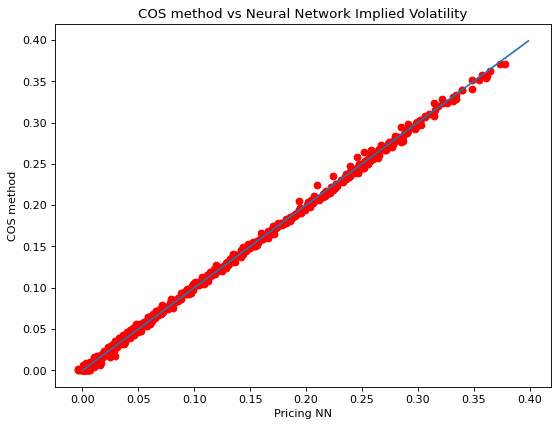

In [72]:
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(X[0], Y[0], c ="r"),plt.scatter(X[1], Y[1], c ="r"),plt.scatter(X[2], Y[2], c ="r"),plt.scatter(X[3], Y[3], c ="r"),plt.scatter(X[4], Y[4], c ="r")
plt.scatter(X[5], Y[5], c ="r"),plt.scatter(X[6], Y[6], c ="r"),plt.scatter(X[7], Y[7], c ="r"),plt.scatter(X[8], Y[8], c ="r"),plt.scatter(X[9], Y[9], c ="r")
plt.scatter(X[10], Y[10], c ="r"),plt.scatter(X[11], Y[11], c ="r"),plt.scatter(X[12], Y[12], c ="r"),plt.scatter(X[13], Y[13], c ="r"),plt.scatter(X[14], Y[14], c ="r")
plt.scatter(X[15], Y[15], c ="r"),plt.scatter(X[16], Y[16], c ="r"),plt.scatter(X[17], Y[17], c ="r"),plt.scatter(X[18], Y[18], c ="r"),plt.scatter(X[19], Y[19], c ="r")
plt.scatter(X[20], Y[20], c ="r"),plt.scatter(X[21], Y[21], c ="r"),plt.scatter(X[22], Y[22], c ="r"),plt.scatter(X[23], Y[23], c ="r"),plt.scatter(X[24], Y[24], c ="r")
plt.scatter(X[25], Y[25], c ="r"),plt.scatter(X[26], Y[26], c ="r"),plt.scatter(X[27], Y[27], c ="r"),plt.scatter(X[28], Y[28], c ="r"),plt.scatter(X[29], Y[29], c ="r")
plt.xlabel("Pricing NN")
plt.ylabel("COS method")
plt.title("COS method vs Neural Network Implied Volatility")
plt.plot(x,x)
#plt.savefig('pricing_peformance21.png')
plt.show()

# Saving the Pricng NN

In [ ]:
#VG_pricer.save('Variance_Gamma_Pricing_NN.h5')

#For calibration, we load a pre-trained model

In [5]:
VG_pricer = load_model('/content/Variance_Gamma_Pricing_NN_Weights.h5') 

In [140]:
S0=1.
K=np.array([0.8,0.9,1.0,1.1, 1.2], dtype=np.float32)
T=np.array([.5,.75,1.,1.25], dtype=np.float32)

# Constructing the calibrator

To make the calibrator more stable, we construct an actiation function which fits the range of each parameter, and this was achived through modifying the sigmoid function.

In [141]:
def modified_sigmoid(x,a = 0.0,b = 1.0,c = 0.0,d = 1.0): #Modified sigmoid
    return (b-a)*tf.math.sigmoid( (x-c)/d ) + a

@tf.function 
def custom_activation(x): #activation function
    return tf.stack([modified_sigmoid(x[...,0],0.0,0.2,0.1,0.05), modified_sigmoid(x[...,1],0.0,0.2,0.1,0.05),
                     modified_sigmoid(x[...,2],-0.3,0.05,-.1525,0.05), modified_sigmoid(x[...,3],0.0,0.7,.35,0.05) ], axis = 1)

The calibrator NN is set up in such a way that the parameters being trained are the weights from the first hidden layer, thus the bias from this layer is deactivated.

In [142]:
calibrator=Sequential([
    Dense(4, input_dim= 1, use_bias=False , kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),
          activation = custom_activation),
    Dense(16, activation ="relu", input_shape=(4,)),
    Dense(64, activation ="relu"),
    Dense(64, activation ="relu"),
    Dense(32, activation ="relu"),
    Dense(len(K)*len(T))
])
#setting and fixing the weights obtained from the pricing NN
for i in range(1, len(calibrator.layers)):
    calibrator.layers[i].set_weights(VG_pricer.layers[i-1].weights)
    calibrator.layers[i].trainable=False 
calibrator.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 4)                 4         
                                                                 
 dense_73 (Dense)            (None, 16)                80        
                                                                 
 dense_74 (Dense)            (None, 64)                1088      
                                                                 
 dense_75 (Dense)            (None, 64)                4160      
                                                                 
 dense_76 (Dense)            (None, 32)                2080      
                                                                 
 dense_77 (Dense)            (None, 20)                660       
                                                                 
Total params: 8,072
Trainable params: 4
Non-trainable

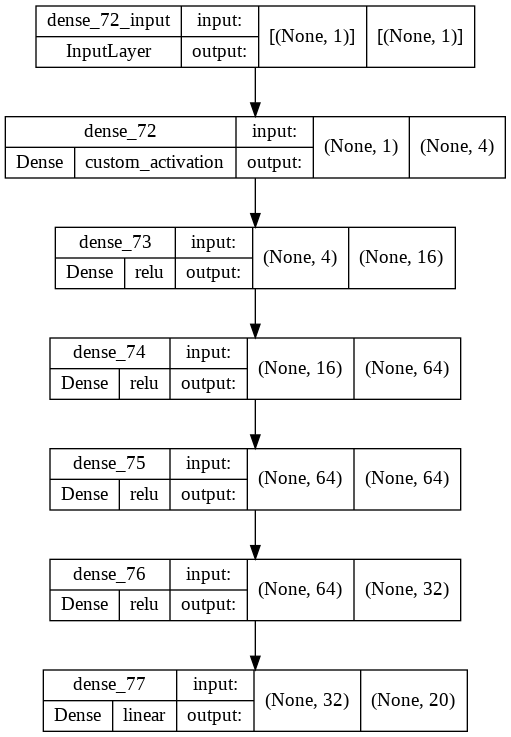

In [143]:
plot_model(calibrator,show_shapes=True,show_layer_activations=True)

The calibrator inputs a vector of $[1]$, then learns the weights of the first hidden layer which are the parameters of interest in this case, thus we create an already exist set of option prices

In [144]:
r = np.random.uniform(low = 0, high = 0.2)
sig = np.random.uniform(low = 0.0, high = 0.2)
theta = np.random.uniform(low =-0.3, high = 0.05 )
nu = np.random.uniform(low = 0.0, high = 0.7 )

pars_act = np.array([[r,sig,theta,nu]])  #Paramerts to calibrate
y = VG_pricer(pars_act).numpy() #Represents market observed prices

def scheduler(epoch, lr):
      if epoch % 10==0:
        return lr*0.98
      else:
        return lr 
    
for _ in range(8): #training the calibrator
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    calibrator.compile(loss = "mse" , optimizer= optimizer,metrics = ["accuracy"])
    callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    history = calibrator.fit(np.array([[1.]]), y, epochs = 100, verbose = 0, callbacks = [callback])

calibrator.evaluate(np.array([[1.]]), y) #evaluation to check training performance
hidden_weights = calibrator.layers[0].weights[0].numpy() #exatracting the first layer weights
pars_pred = custom_activation(hidden_weights).numpy()  #passing the weight throughh the custom activation

print(2*"\n",pars_pred,"Prediction""\n",pars_act,"Actual") #Predicted vs actual parameters

1/1 [==============================] - 0s 147ms/step - loss: 6.2422e-07 - accuracy: 1.0000


 [[ 0.04456528  0.1340168  -0.22824925  0.00149129]] Prediction
 [[ 0.03240618  0.12625998 -0.22751179  0.10718318]] Actual


#Actual Parameters vs Calibrated Parameters

In [145]:
Y = [] #actual
X = [] #predicted

for j in range(30):
    def scheduler(epoch, lr):
        if epoch % 10==0:
            return lr*0.98
        else:
            return lr
    ########################################
    r = np.random.uniform(low = 0, high = 0.2)
    sig = np.random.uniform(low = 0.0, high = 0.2)
    theta = np.random.uniform(low =-0.3, high = 0.05 )
    nu = np.random.uniform(low = 0.0, high = 0.7 )

    ############################################### Actual
    y_act = np.zeros((len(T),len(K)))
    for i in range(len(T)):
        y_act[i,:] = VG_EuroCall(S0,K,T[i],r,sig,theta,nu,256)
    y_act = np.array(tf.reshape(y_act, (1,20)))
    Y.append(y_act[0])
    ############################################### 
    
    for _ in range(8):
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
        calibrator.compile(loss = "mse" , optimizer= optimizer,metrics = ["accuracy"])
        callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
        history = calibrator.fit(np.array([[1.]]), y_act, epochs = 100, verbose = 0, callbacks = [callback])

    calibrator.evaluate(np.array([[1.]]), y) 
    w = calibrator.layers[0].weights[0].numpy() 
    pars_pred = custom_activation(w).numpy() 

    ###################################################### Prediction
    y_pred = np.zeros((len(T),len(K)))
    for i in range(len(T)):
        y_pred[i,:] = VG_EuroCall(S0,K,T[i],pars_pred[0][0],pars_pred[0][1],pars_pred[0][2],pars_pred[0][3],256)
    y_pred = np.array(tf.reshape(y_pred, (1,20)))
    X.append(y_pred[0])

1/1 [==============================] - 0s 167ms/step - loss: 2.7381e-04 - accuracy: 1.0000


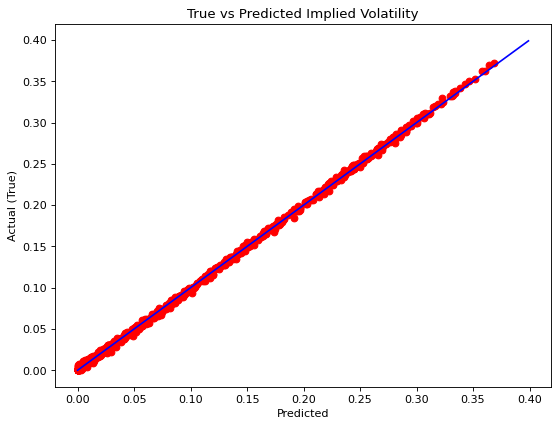

In [146]:
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(X[0], Y[0], c ="r"),plt.scatter(X[1], Y[1], c ="r"),plt.scatter(X[2], Y[2], c ="r"),plt.scatter(X[3], Y[3], c ="r"),plt.scatter(X[4], Y[4], c ="r")
plt.scatter(X[5], Y[5], c ="r"),plt.scatter(X[6], Y[6], c ="r"),plt.scatter(X[7], Y[7], c ="r"),plt.scatter(X[8], Y[8], c ="r"),plt.scatter(X[9], Y[9], c ="r")
plt.scatter(X[10], Y[10], c ="r"),plt.scatter(X[11], Y[11], c ="r"),plt.scatter(X[12], Y[12], c ="r"),plt.scatter(X[13], Y[13], c ="r"),plt.scatter(X[14], Y[14], c ="r")
plt.scatter(X[15], Y[15], c ="r"),plt.scatter(X[16], Y[16], c ="r"),plt.scatter(X[17], Y[17], c ="r"),plt.scatter(X[18], Y[18], c ="r"),plt.scatter(X[19], Y[19], c ="r")
plt.scatter(X[20], Y[20], c ="r"),plt.scatter(X[21], Y[21], c ="r"),plt.scatter(X[22], Y[22], c ="r"),plt.scatter(X[23], Y[23], c ="r"),plt.scatter(X[24], Y[24], c ="r")
plt.scatter(X[25], Y[25], c ="r"),plt.scatter(X[26], Y[26], c ="r"),plt.scatter(X[27], Y[27], c ="r"),plt.scatter(X[28], Y[28], c ="r"),plt.scatter(X[29], Y[29], c ="r")
plt.xlabel("Predicted")
plt.ylabel("Actual (True)")
plt.title("True vs Predicted Implied Volatility")
plt.plot(x,x,color = "b")
#plt.savefig('calibration_peformance15.png')
plt.show()